In [1]:
import jax
import jax.numpy as np
import scipy
from jax import random, grad,value_and_grad, vmap, jit, hessian, lax
from jax.lax.linalg import qr
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax import flatten_util
import itertools
from functools import partial
from tqdm import trange, tqdm
import numpy as np0
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import scipy.io as sio
import tqdm as tqdm
import sys
import os
from sklearn.model_selection import train_test_split


from scipy.interpolate import griddata
%matplotlib inline

file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

from flax import linen as nn
import jax.numpy as jnp
from typing import Sequence, Callable

from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *



Project root: /oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs


In [2]:
cmap = 'RdBu'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


In [3]:
Save_name='cKAN'

## Load Data


In [4]:
data=scipy.io.loadmat(project_root+'/Data/Burger_100pi_5000.mat')
print(data.keys())
s_all=data['output']
print(s_all.shape)
s_all = np.reshape(s_all, (s_all.shape[0], s_all.shape[1]*s_all.shape[2]))
print(s_all.shape)
f_all=data['input']
print(f_all.shape)
x_all=np.linspace(0, 1, f_all.shape[1])
t_all=np.linspace(0, 1, f_all.shape[1])
T, X = np.meshgrid(t_all, x_all)
y_all = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
print(y_all.shape)

dict_keys(['__header__', '__version__', '__globals__', 'gamma', 'input', 'output', 'sigma', 'tau', 'tspan'])
(5000, 101, 101)
(5000, 10201)
(5000, 101)
(10201, 2)


# Training-Testing Data

In [5]:
# Calculate the sizes for each split
train_size = 0.7

# First, split off the training data
s_train, s_test, f_train, f_test = train_test_split(s_all, f_all, train_size=train_size, random_state=42)

# Reshape the data 
s_train = np.float32(s_train)
y_train = np.float32(y_all)
f_train = np.float32(f_train)
# Reshape the data 
s_test = np.float32(s_test)
f_test = np.float32(f_test)
y_train = np.float32(y_train)

# Print shapes to verify
print("s_train shape:", s_train.shape)
print("f_train shape:", f_train.shape)
print("s_test shape:", s_test.shape)
print("f_test shape:", f_test.shape)

s_train shape: (3500, 10201)
f_train shape: (3500, 101)
s_test shape: (1500, 10201)
f_test shape: (1500, 101)


In [6]:
X_DN={'F':f_train,
      'y':y_train,
      'S':s_train,}
X_DN['F'].shape

X_Test={'F':f_test,
      'y':y_train,
      'S':s_test,}
X_DN['X_Test']=X_Test

# Architecture

In [7]:
class KAN(nn.Module):
    layers: Sequence[int]
    degree: int =5
    @nn.compact
    def __call__(self, x):
        for feat in self.layers:
            x = Cheby_KAN_layer(out_dim=feat, degree=self.degree)(x)
        return x


# DeepONet

In [8]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers,X_data, trunk_layers,batch_size,output_dim):  

         # Define branch and trunk networks using Flax MLP
        self.branch_net = KAN(branch_layers)
        self.trunk_net = KAN(trunk_layers) 

        # Initialize parameters
        rng_branch = random.PRNGKey(1234)
        rng_trunk = random.PRNGKey(4321)
        
        # Sample inputs for initialization
        sample_F = X_data['F'][0:10]  # Adjust as needed
        sample_y = X_data['y'][0:10]  # Adjust as needed
        
        branch_params = self.branch_net.init(rng_branch, sample_F)
        trunk_params = self.trunk_net.init(rng_trunk, sample_y)
        # JIT-compile the apply functions
        self.branch_apply_fn = jax.jit(self.branch_net.apply)
        self.trunk_apply_fn = jax.jit(self.trunk_net.apply)
        # Initialize
        self.batch_size=batch_size
        A= []
        params = (branch_params, trunk_params,A)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3/3, 
                                                                      decay_steps=2500, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)
        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log_T = []
        self.it_log_T = []
        self.loss_log_B = []
        self.it_log_B = []
        self.train_L2 = []
        self.test_L2 = []
        self.eta=0.01
        self.max_RBA0=10.0
    # Define loss data

    def loss_all(self, params, y,F,U):
        branch_params, trunk_params, A = params
        B = self.branch_apply_fn(branch_params, F)
        T = self.trunk_apply_fn(trunk_params, y).T
        outputs = B @ T
        R=outputs-U.T
        loss=np.mean((R)**2)
        return  loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step_all(self, i, opt_state,y,F,U):
        params = self.get_params(opt_state)
        g = grad(self.loss_all)(params, y,F,U)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train_all(self, X_data, nIter = 10000,cap_RBA=40):
        y=X_data['y']
        U0=X_data['S']
        pbar = trange(nIter+1)
        for it in  pbar:
            key = jax.random.PRNGKey(it)
            key, subkey = jax.random.split(key)  
            idx_train=np.arange(len(U0))
            #Select
            U=X_data['S'][idx_train]
            U=U.T
            F=X_data['F'][idx_train]
            computed=0
            self.opt_state= self.step_all(next(self.itercount), self.opt_state, y,F,U)
            if it<100 or it % 100 == 0:
                params = self.get_params(self.opt_state) 
                loss_value = self.loss_all(params, y,F,U)
                error_test, error_train  =self.test_error(params, X_data)
                # Store losses
                self.loss_log_T.append(loss_value)
                self.it_log_T.append(it)
                self.train_L2.append(error_train)
                self.test_L2.append(error_test)

                # Print losses
                pbar.set_postfix({'it':it,
                                  'Loss': loss_value,
                                  'Train RL2':error_train,
                                  'Test RL2':error_test})
    def predict_all(self, params, X_data):
        # Perform QR decomposition
        branch_params, trunk_params,A = params
        y=X_data['y']
        U=X_data['S'].T
        F=X_data['F']
        T = self.trunk_apply_fn(trunk_params, y).T
        B = self.branch_apply_fn(branch_params, F)
        U_pred = B @ T
        return U_pred
    def test_error(self, params, X_data):
        u_pred = self.predict_all(params, X_data)
        error_train = np.linalg.norm(X_data['S'] - u_pred) / np.linalg.norm(X_data['S'])
        X_Test=X_data['X_Test']
        u_pred = model.predict_all(params, X_Test)
        error_test = np.linalg.norm(X_Test['S'] - u_pred) / np.linalg.norm(X_Test['S']) 
        return error_test, error_train  
        

## Initialize Model

In [9]:
N=840
m=101
batch_size=500
num_layer=5
width_layer=32
embed_dim=m
# Initialize model
branch_layers = num_layer*[width_layer] +[embed_dim]
trunk_layers =  num_layer*[width_layer] +[embed_dim]
print(branch_layers)
print(trunk_layers)
model = DeepONet(branch_layers,X_DN, trunk_layers,batch_size,output_dim=embed_dim)

[32, 32, 32, 32, 32, 101]
[32, 32, 32, 32, 32, 101]


2025-06-13 00:07:36.796871: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot on a single thread.
2025-06-13 00:07:41.477225: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot on a single thread.
2025-06-13 00:07:44.441629: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 33 configs for gemm_fusion_dot on a single thread.
2025-06-13 00:07:48.252224: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 2 configs for gemm_fusion_dot on a single thread.


In [10]:
params_save=model.get_params(model.opt_state)
total_params = sum(x.size for x in jax.tree_util.tree_leaves(params_save) if hasattr(x, 'size'))
print(total_params)

107712


# Train

In [11]:
# Train
model.train_all(X_DN, nIter=400000)

  0%|          | 0/400001 [00:00<?, ?it/s]2025-06-13 00:07:50.158206: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 635 configs for 19 fusions on a single thread.
2025-06-13 00:10:49.261762: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot.3 on a single thread.
2025-06-13 00:11:03.026292: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 104 configs for 3 fusions on a single thread.
2025-06-13 00:11:19.599105: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot.3 on a single thread.
100%|██████████| 400001/400001 [35:18<00:00, 188.81it/s, it=4e+5, Loss=3.268813e-05, Train RL2=0.0307755, Test RL2=0.037027515]     


In [12]:
params_save=model.get_params(model.opt_state)

## Save Parameters

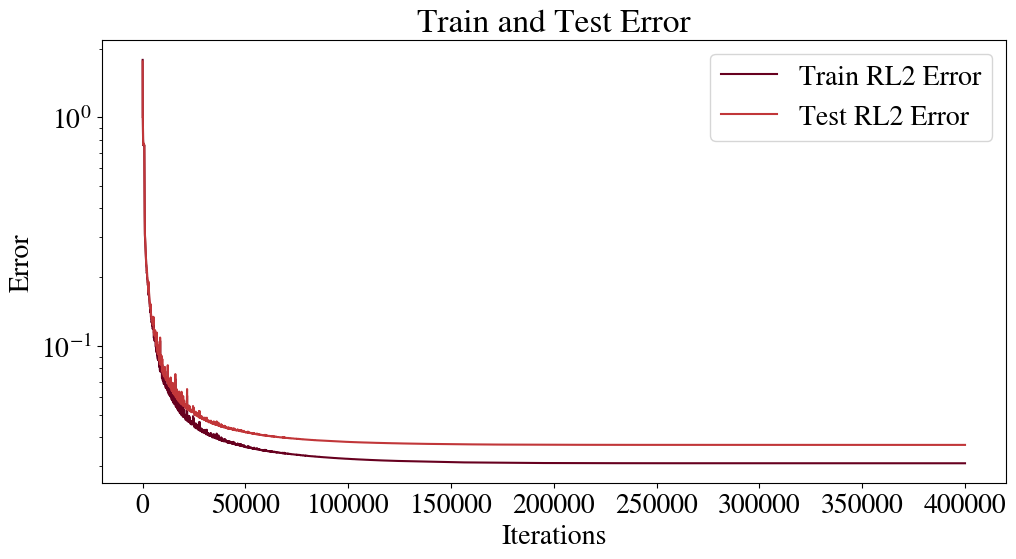

In [13]:
Loss_T=model.loss_log_T
it_T=model.it_log_T
Loss_B=model.loss_log_B
it_B=model.it_log_B
Train_error=model.train_L2
Test_error=model.test_L2

# Adding an additional subplot for Train and Test error

plt.figure(figsize=(20, 6))  # Adjusted figure size to accommodate three subplots

# Plot for Train and Test error
plt.subplot(1, 2, 2)
plt.plot(it_T, Train_error, label='Train RL2 Error')
plt.plot(it_T, Test_error, label='Test RL2 Error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')  # Setting log scale for y-axis
plt.title('Train and Test Error')
plt.legend()

# Displaying the plots
plt.tight_layout()
plt.show()


In [14]:
file_mat=Save_name+'_Errors.mat'
print(file_mat)
all_results={
    'Test':Test_error,
    'Train':Train_error,
    'it':it_T,
}
scipy.io.savemat(file_mat,all_results)

cKAN_Errors.mat


In [15]:
params=jax.device_get(model.get_params(model.opt_state))

In [16]:
u_pred = model.predict_all(params, X_DN)
error_s = np.linalg.norm(X_DN['S'] - u_pred) / np.linalg.norm(X_DN['S'])

print(u_pred.shape)
print(error_s)

params=model.get_params(model.opt_state)
u_pred = model.predict_all(params, X_Test)
error_s = np.linalg.norm(X_Test['S'] - u_pred) / np.linalg.norm(X_Test['S'])

print(u_pred.shape)
print(error_s)

(3500, 10201)
0.0307755
(1500, 10201)
0.037027515


Sample 15 error_s: 3.970e-02
Sample 50 error_s: 2.071e-02
Sample 499 error_s: 1.841e-02


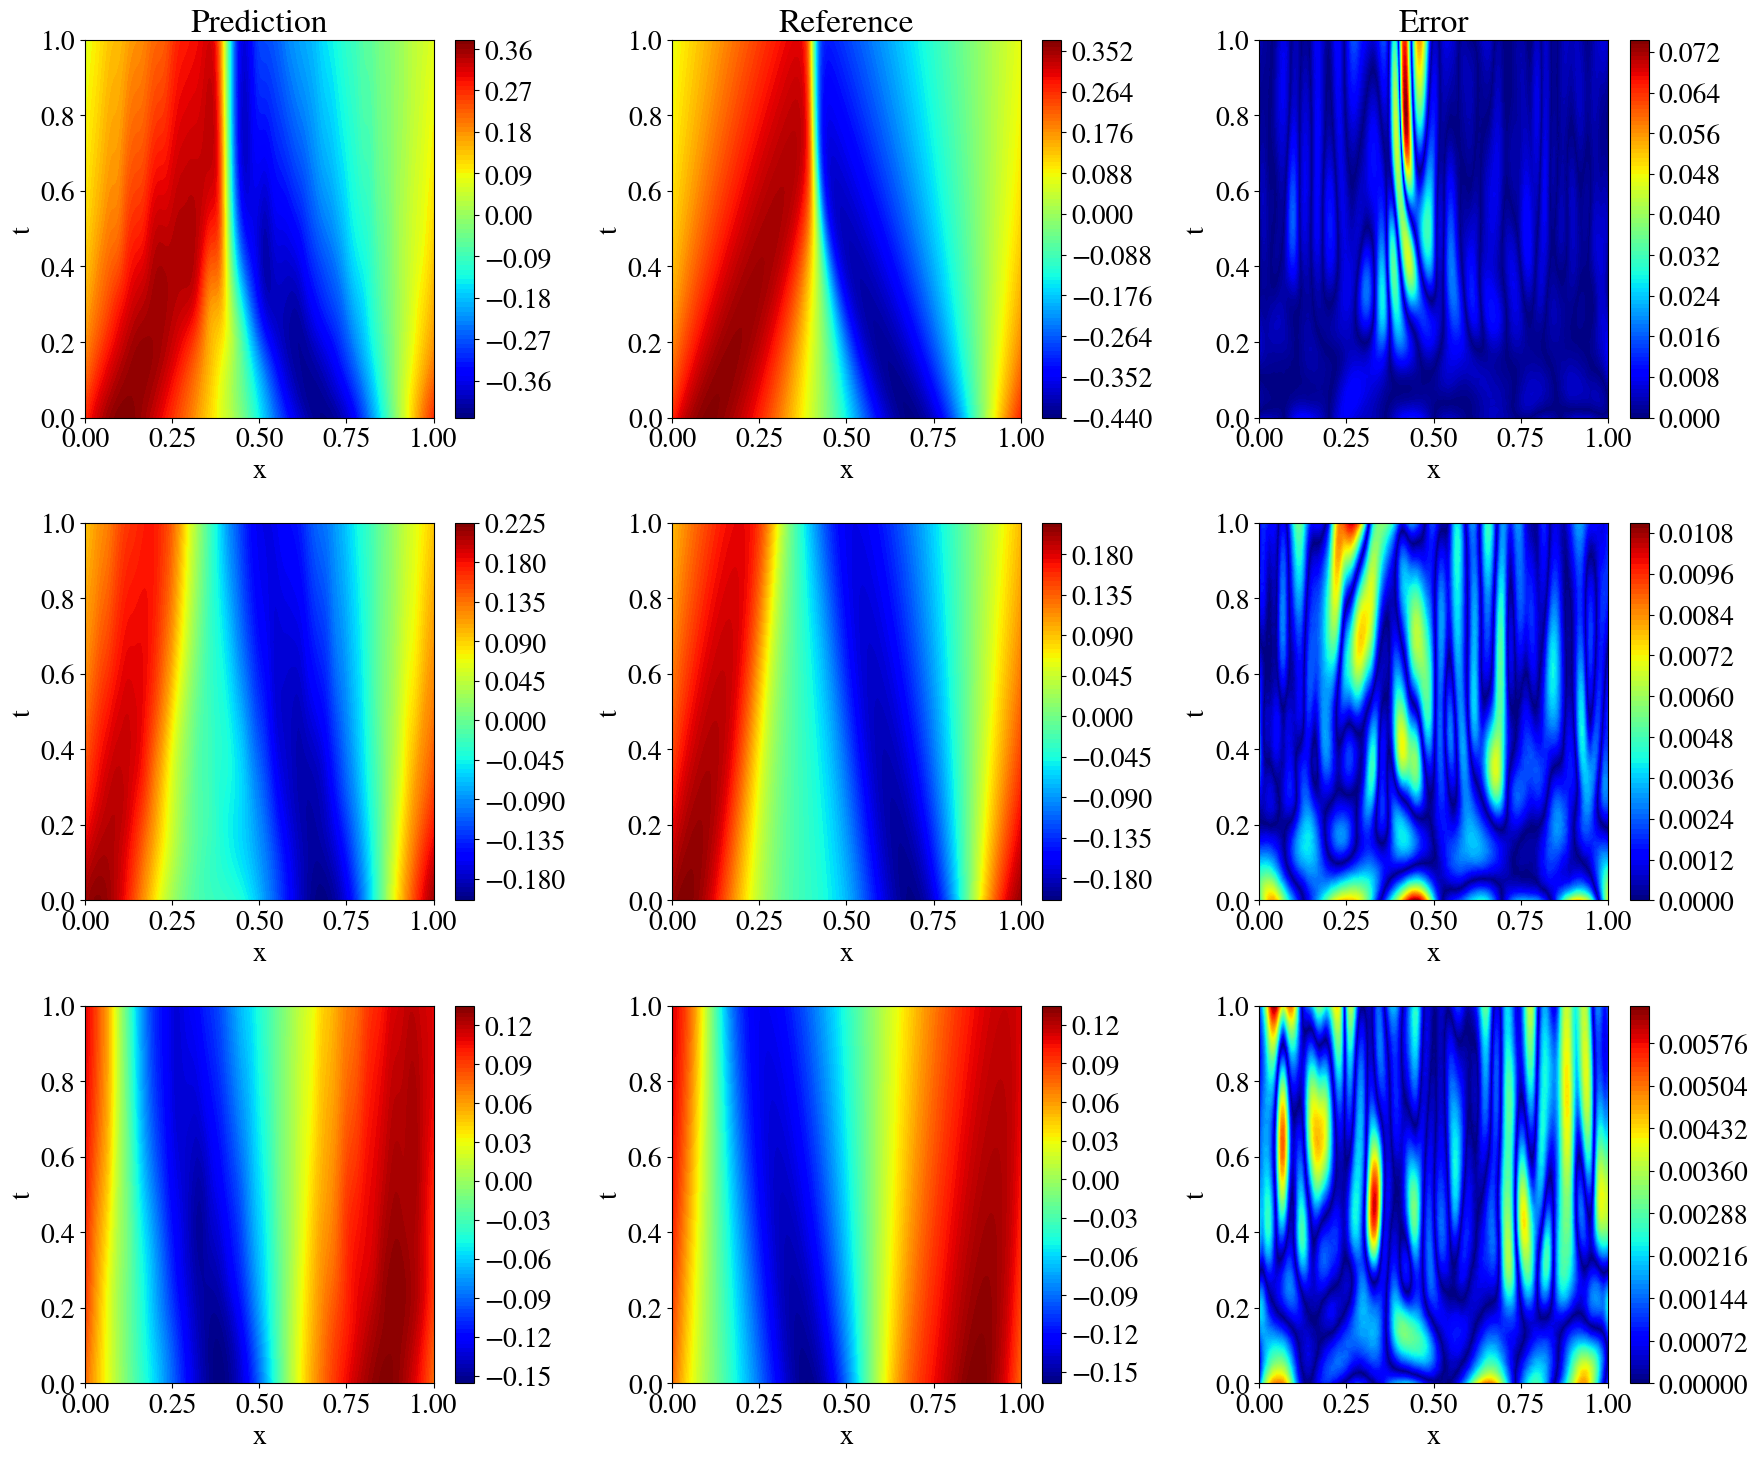

In [17]:
samples = [15, 50, 499]

# Generate a uniform mesh
x = np0.linspace(0, 1, N)
t = np0.linspace(0, 1, N)
XX, TT = np0.meshgrid(x, t)

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

for row_idx, sample in enumerate(samples):
    # Retrieve the test and predicted data for the current sample
    u_test_sample = np0.array(X_Test['S'][sample])
    u_pred_sample = np0.array(u_pred[sample])

    # Compute the relative error
    error_s = np0.linalg.norm(u_test_sample - u_pred_sample, 2) / np0.linalg.norm(u_test_sample, 2)
    print(f"Sample {sample} error_s: {error_s:.3e}")

    # Grid data
    S_pred = griddata(X_Test['y'], u_pred_sample.flatten(), (XX, TT), method='cubic')
    S_test = griddata(X_Test['y'], u_test_sample.flatten(), (XX, TT), method='cubic')
    pointwise_error = np0.abs(S_test - S_pred)

    # Plot Real u
    ax = axes[row_idx, 1]
    contour1 = ax.contourf(XX, TT, S_test, levels=100, cmap='jet')
    fig.colorbar(contour1, ax=ax)
    if row_idx==0:
        ax.set_title(f'Reference')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    # Plot Predicted u
    ax = axes[row_idx, 0]
    contour2 = ax.contourf(XX, TT, S_pred, levels=100, cmap='jet')
    fig.colorbar(contour2, ax=ax)
    if row_idx==0:
        ax.set_title(f'Prediction')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    # Plot Pointwise Error
    ax = axes[row_idx, 2]
    contour3 = ax.contourf(XX, TT, pointwise_error, levels=100, cmap='jet')
    fig.colorbar(contour3, ax=ax)
    if row_idx==0:
        ax.set_title(f'Error')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

plt.tight_layout()
plt.savefig('KAR_results.png',dpi=300)
plt.show()

# If needed, update JAX configuration
jax.config.update("jax_enable_x64", False)
